# Deployable Payload

Here we try to demonstrate how to use RocketPy to simulate a flight of a rocket
that presents a deployable payload.

## Initializations for Google Colab

To run this notebook, we will need:

*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/RocketPy-Team/RocketPy.git

In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

## Simulation

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using a version of Jupyter Notebooks, it is recommended to run the following lines of code to make plots that will be shown later interactive and/or higher quality.

In [2]:
%matplotlib inline

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [3]:
env = Environment(
    latitude=32.990254, longitude=-106.974998, elevation=1400
)

To get weather data from the GFS forecast, available online, we run the following lines.
See [Environment Class Usage](environment/environment_class_usage.ipynb) for more information on how to use the Environment class.

In [4]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

env.set_atmospheric_model(type="Forecast", file="GFS")
env.max_expected_height = 8000


Gravity Details

Acceleration of Gravity at Lauch Site: 9.79111266229703 m/s²


Launch Site Details

Launch Date: 2023-08-08 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 8.000 km
Forecast Time Period: From  2023-08-07 18:00:00  to  2023-08-23 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 2.90 m/s
Surface Wind Direction: 347.21°
Surface Wind Heading: 167.21°
Surface Pressure: 855.98 hPa
Surface Temperature: 296.24 K
Surface Air Density: 1.007 kg/m³
Surface Speed of Sound: 345.03 m/s


Atmospheric Model Plots



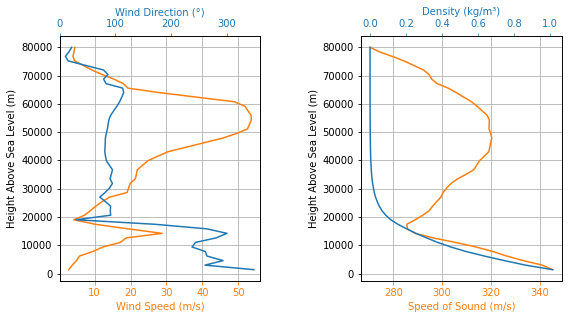

In [5]:
env.info()

### Creating a Motor

A solid rocket motor is used in this case.

In [6]:
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

Nozzle Details
Nozzle Radius: 0.033 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.005 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.033 m
Grain Inner Radius: 0.015 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.591 kg

Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Average Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns



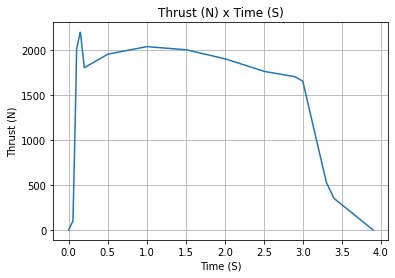

In [7]:
Pro75M1670.info()

## Simulating the First Flight Stage

Let's start to simulate our rocket's flight. We will use the Environment and Motor objects we created before.

We will assume that the payload is ejected at apogee, however, this can be modified if needed.

We start by defining the value of each relevant mass, ensuring they are correct before continuing.

In [8]:
# 14.426 is the mass of the rocket including the payload but without the motor
payload_mass = 4.5  # in kg
rocket_mass = 14.426 - payload_mass  # in kg

print("Rocket Mass Without Motor: {:.4} kg (with Payload)".format(rocket_mass + payload_mass))
print("Loaded Motor Mass: {:.4} kg".format(Pro75M1670.total_mass(0)))
print("Payload Mass: {:.4} kg".format(payload_mass))
print(
    "Fully loaded Rocket Mass: {:.4} kg".format(
        rocket_mass + Pro75M1670.total_mass(0) + payload_mass
    )
)

Rocket Mass Without Motor: 14.43 kg (with Payload)
Loaded Motor Mass: 4.771 kg
Payload Mass: 4.5 kg
Fully loaded Rocket Mass: 19.2 kg


Then we define our rocket.

In [9]:
rocket_with_payload = Rocket(
    radius=127 / 2000,
    mass=rocket_mass + rocket_mass,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rocket_with_payload.add_motor(Pro75M1670, position=-1.255)

rocket_with_payload.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket_with_payload.add_nose(
    length=0.55829, kind="von karman", position=1.278
)

rocket_with_payload.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../data/calisto/NACA0012-radians.csv","radians"),
)

rocket_with_payload.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

In [10]:
rocket_with_payload.info()


Inertia Details

Rocket Mass: 19.852 kg
Rocket Dry Mass: 21.667 kg (With Motor)
Rocket Mass: 24.623 kg (With Propellant)
Rocket Inertia (with motor, but without propellant) 11: 7.909 kg*m2
Rocket Inertia (with motor, but without propellant) 22: 7.909 kg*m2
Rocket Inertia (with motor, but without propellant) 33: 0.036 kg*m2
Rocket Inertia (with motor, but without propellant) 12: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 13: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 23: 0.000 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass withour Motor: 0.079 m
Rocket Center of Dry Mass - Nozzle Exit Distance: 1.176 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.779 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.094 m


Aerodynamics Lift Coefficient Derivatives

Nosecone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficie

Finally we create the flight simulation of this rocket, stopping at apogee

In [11]:
flight_with_payload = Flight(
    rocket=rocket_with_payload,
    environment=env,
    rail_length=5.2,
    inclination=85,
    heading=25,
    terminate_on_apogee=True,
    name="Rocket Flight With Payload",
)

## Start the Second Flight Stage

Now we will simulate the second flight stage, which is the landing phase of our Rocket.
Here we will consider that the payload was ejected at the apogee of the first stage.
Therefore we should be careful with the value of its mass.

In [12]:
rocket_without_payload = Rocket(
    radius=127 / 2000,
    mass=rocket_mass,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)


# Define Parachutes for the rocket
Main = rocket_without_payload.add_parachute(
    "Main",
    cd_s=7.2,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket_without_payload.add_parachute(
    "Drogue",
    cd_s=0.72,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

In [13]:
rocket_without_payload.info()


Inertia Details

Rocket Mass: 9.926 kg
Rocket Dry Mass: 9.926 kg (With Motor)
Rocket Mass: 9.926 kg (With Propellant)
Rocket Inertia (with motor, but without propellant) 11: 6.321 kg*m2
Rocket Inertia (with motor, but without propellant) 22: 6.321 kg*m2
Rocket Inertia (with motor, but without propellant) 33: 0.034 kg*m2
Rocket Inertia (with motor, but without propellant) 12: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 13: 0.000 kg*m2
Rocket Inertia (with motor, but without propellant) 23: 0.000 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass withour Motor: 0.000 m
Rocket Center of Dry Mass - Nozzle Exit Distance: 0.000 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.000 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.000 m


Aerodynamics Lift Coefficient Derivatives


Aerodynamics Center of Pressure

Distance - Center of Pressure to Cen

The line `initial_solution=flight_with_payload` will make the simulation start from the end of the first stage. 

This will simulate our rocket with its payload ejected, after reaching apogee.

In [14]:
flight_without_payload = Flight(
    rocket=rocket_without_payload,
    environment=env,
    rail_length=5.2, # does not matter since the flight is starting at apogee
    inclination=0,
    heading=0,
    initial_solution=flight_with_payload,
    name="Rocket Flight Without Payload",
)

## Simulating the Third Flight Stage - Payload Flight

Here we will simulate the payload flight, which is the third flight stage of our Rocket.
The Payload will be ejected at the apogee of the first stage.
Here, it will be modeled as a "dummy" rocket, which does not have any aerodynamic surfaces to stabilize it, nor a motor that ignites.
It does, however, have parachutes.

In [15]:
# Define the "Payload Rocket"

payload_rocket = Rocket(
    radius=127 / 2000,
    mass=payload_mass,
    inertia=(0.1,0.1,0.001),
    power_off_drag=0.5,
    power_on_drag=0.5,
    center_of_mass_without_motor=0
)

payload_drogue = payload_rocket.add_parachute(
    "Drogue",
    cd_s=0.35,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

payload_main = payload_rocket.add_parachute(
    "Main",
    cd_s=4.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

The magic line `initialSolution=RocketFlight1` will make the simulation start from the end of the first stage.

In [16]:
payload_flight = Flight(
    rocket=payload_rocket,
    environment=env,
    rail_length=5.2, # does not matter since the flight is starting at apogee
    inclination=0,
    heading=0,
    initial_solution=flight_with_payload,
    name="PayloadFlight",
)

## Plotting Everything together

We will invoke a method from RocketPy's utilities class in order to visualize 
the trajectory.

In [17]:
from rocketpy.plots.compare import CompareFlights

Then we create the `comparison` object, an instance of CompareFligths class

In [18]:
comparison = CompareFlights([flight_with_payload, flight_without_payload, payload_flight])

And, finally, we are able to plot different aspects of the comparison object.

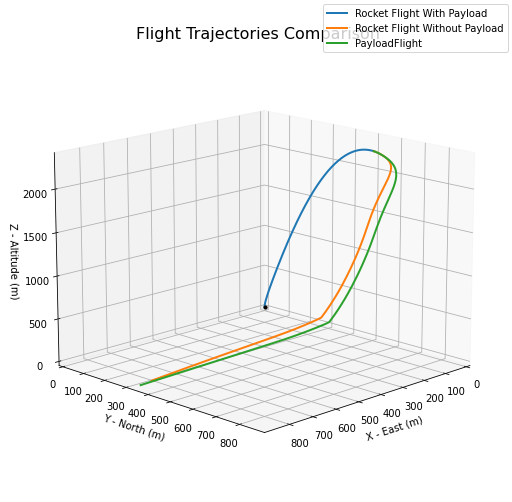

In [19]:
comparison.trajectories_3d(legend=True)

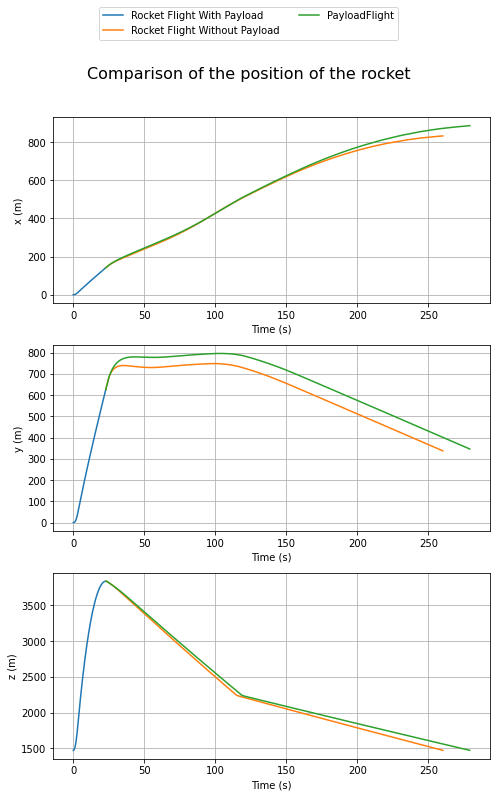

In [20]:
comparison.positions()

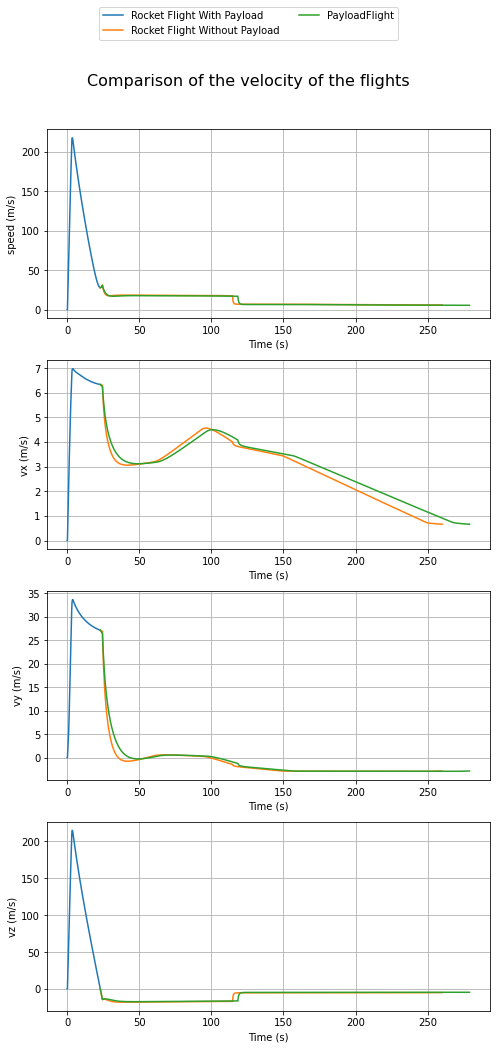

In [21]:
comparison.velocities()

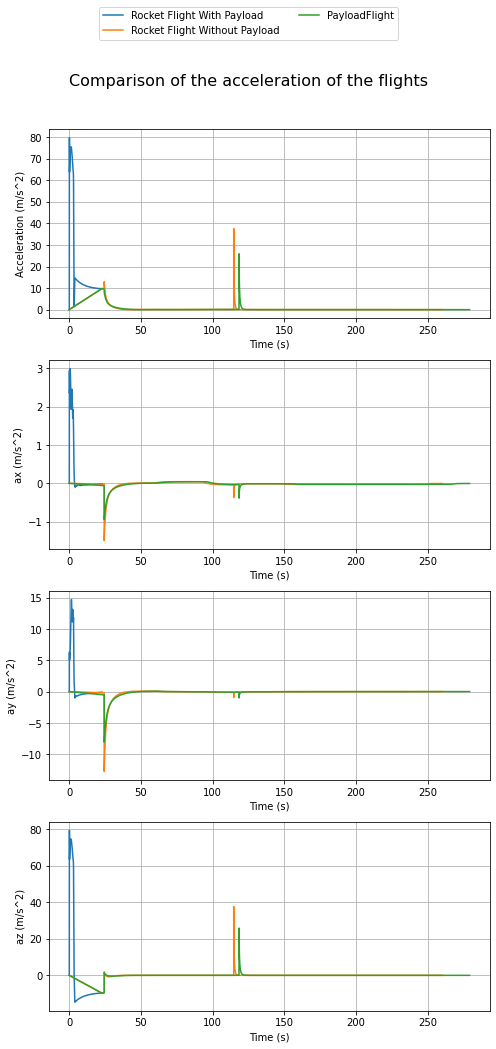

In [22]:
comparison.accelerations()

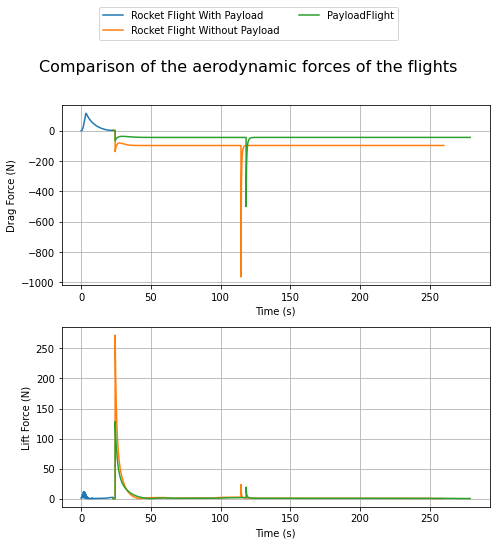

In [23]:
comparison.aerodynamic_forces()

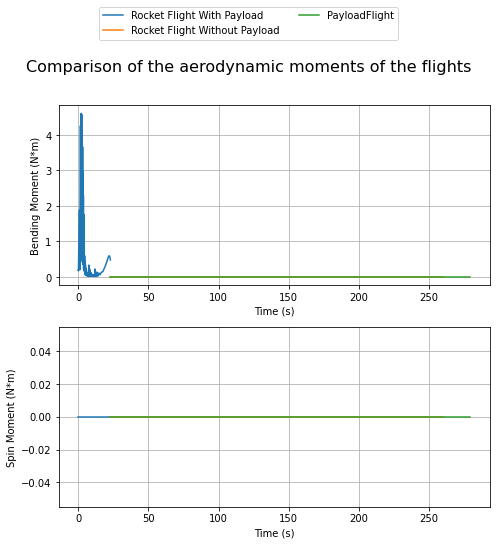

In [24]:
comparison.aerodynamic_moments()

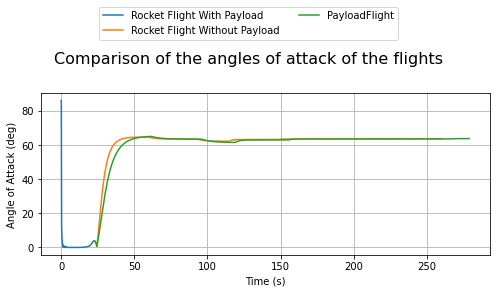

In [25]:
comparison.angles_of_attack()